<a href="https://colab.research.google.com/github/ganjiron/ganpython/blob/master/%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8_TQQQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install finterstellar

In [ ]:
import finterstellar as fs
import numpy as np
import pandas as pd
from re import S
import pandas as pd
import pandas_datareader.data as web


class BackTestAPI():
    def __init__(self ,start_date , end_date , debug_level = 0 , split = 40 , ETF = "TQQQ"):
        self.df = fs.get_ohlc(ETF, start_date, end_date)
        # df1 = fs.get_ohlc(ETF, start_date, end_date)
        # df2 = fs.rsi(df1 , w=14)
        # self.df = pd.merge(df1,df2)
        self.df["cmt"] = np.nan  # New Cycle signal
        self.df["scnt"] = np.nan  # Stock Count
        self.df["smean"] = np.nan  # 평단가
        self.df["smoney"] = np.nan  # 시드머니
        self.df["현재회차"] = np.nan  # 현재 회차
        self.df["벌어서뺀돈"] = np.nan  # 벌어서 뺀돈 합계
        self.initMoney = 200000  # 초기자금
        self.고정된돈 = 200000
        self.splitCount = split  # 분할 횟수
        self.oneMoney = self.고정된돈 / self.splitCount  # 1회치 매수 대금 무조건 fix
        self.stockCount = 0  # 보유 주식 수
        self.stockMeanValue = 0  # 보유주식 평단가
        self.buyCount = 0  # 매수 주식 수
        self.SELL_RATE = 1.10  # 익절 기준
        self.현재회차 = 0
        self.벌어서뺀돈 = 0
        self.dl = debug_level
        return

    def Print(self , debug_level , pvalue ):
        if self.dl >= debug_level:
            print(pvalue)
        else:
            return


    def buy_close(self,close_value, money) :
        #global stockCount, stockMeanValue, buyCount, initMoney
        c = int(money / close_value)
    #     stockMeanValue = round(( ( stockCount * stockMeanValue ) + (c * close_value ) ) / (stockCount + c) , 3)
        self.stockMeanValue = ( ( self.stockCount * self.stockMeanValue ) + (c * close_value ) ) / (self.stockCount + c)
        self.stockCount += c
        self.initMoney -= (close_value * c)
        self.Print(10,"[buy_close] 살돈:{} 남은자본:{} 가진주식수:{} 평단가:{}".format(money,self.initMoney,self.stockCount,self.stockMeanValue))
        return


    # RSI 계산 함수
    def compute_rsi(self , data, window=14):
        diff = data.diff(1).dropna()
        gain = diff.where(diff > 0, 0)
        loss = -diff.where(diff < 0, 0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_momentum_of_rsi(self,rsi_series, window=5):
        return rsi_series.diff(periods=window)

    # Example usage:
    # Assuming `rsi_data` is a Pandas Series of RSI values
    # momentum_rsi = calculate_momentum_of_rsi(rsi_data, window=5)





    # 추가 input을 어느 타이밍까지 기다렸다가 넣을것인가. 고민해보자
    # 1. rsi 가 특정 점수 이하일때 산다.
    # 2. 한방에 다산다? 나눠 산다?
    # 3. 이 인풋은 카운트에 안넣는다.
    def additional_input():

      return


#복리_존버는 아프다
    def backtest_bok(self , buy_percent_1st=1 , buy_percent_2nd = 1.05 , sell_percent_1st = 1.10 , sell_percent_2nd = 1.05 ,
                 sell_amount1 = 0.75,sep=40):
        max_count = 0
        add_per_month = 1000

        # RSI 계산
        print(type(self.df['Close']))
        self.df['RSI'] = self.compute_rsi(self.df['Close'])
        # 모멘텀 다 집어넣기
        self.df['RSI_Momentum'] = self.calculate_momentum_of_rsi(self.df['RSI'], window=5)

        # add_input 넣는 포인트.
        negative_momentum_data = self.df[(self.df['RSI'] < 40) & (self.df['RSI_Momentum'] < 0)]

        # add_input 매달 넣기
        add_money = 0
        previous_month = None

        for idx, row in self.df.iterrows():
            self.Print(8,"---------------현재회차 {} 날짜:{} 종가:{} -----------------------------".format(self.현재회차 , idx,row['Close']))
            is_sell = 0

            current_month = idx.month
            if previous_month is None:
                previous_month = current_month
            elif current_month != previous_month:
                add_money += add_per_month
                previous_month = current_month

            if row['RSI'] < 40 & row['RSI_Momentum'] < 0 & add_money > 0 :
                self.buy_close(float(row['Close']) , add_money)




            if self.현재회차 < 1:  # RSI 확인하고 사는걸로 변경해야함
                self.Print(8,"0회차 매수 종가 : {}".format(row['Close']))
                self.buy_close(float(row['Close']), self.oneMoney)
            elif self.현재회차 < self.splitCount-1:  # 전반전

            # 전반전 매수
                if self.stockMeanValue*buy_percent_1st > float(row['Close']):  # LOC평단 매수
                    self.Print(8,"전반평단매수＊０％ 종가:{} 평단가:{}".format( row['Close'] , self.stockMeanValue))
                    self.buy_close(float(row['Close']), self.oneMoney / 2)
                if self.stockMeanValue * buy_percent_2nd > float(row['Close']):  # LOC평단+5% 매수
                    self.Print(8,"전반평단매수＊5％ 종가:{} 평단가:{}".format(row['Close'], self.stockMeanValue))
                    self.buy_close(float(row['Close']), self.oneMoney / 2)
                tempStockCnt = self.stockCount
                if self.stockMeanValue * sell_percent_1st < float(row['High']):
                    is_sell = 1
                    self.initMoney += (int(self.stockCount * sell_amount1) * self.stockMeanValue * sell_percent_1st)  # 10% 오른 가격으로 75% 주식을 판다.
                    tempStockCnt -= int(self.stockCount * sell_amount1)
                    self.Print(7,"{} 전반평단매도10% sell price:{} 종가:{} tempStockCnt:{}".format(idx,self.stockMeanValue * sell_percent_1st,row['Close'],tempStockCnt))
                if self.stockMeanValue * sell_percent_2nd < float(row['Close']):
                    is_sell = 1
                    self.initMoney += (int(self.stockCount * (1-sell_amount1)) * row['Close'])  # 종가로 25% 주식을 판다.
                    tempStockCnt -= int(self.stockCount * (1-sell_amount1))
                    self.Print(7,
                        "{} 전반loc매도5% sell price:{} 종가:{} tempStockCnt:{}".format(idx , row['Close'], row['Close'],
                                                                               tempStockCnt))
                self.stockCount = tempStockCnt  # 남은 주식 수를 기입하자.
            else:  # 손절
                self.Print(8,"존버")
                tempStockCnt = self.stockCount
                if self.stockMeanValue * sell_percent_1st < float(row['High']):
                    is_sell = 1
                    self.initMoney += (
                                int(self.stockCount * sell_amount1) * self.stockMeanValue * sell_percent_1st)  # 10% 오른 가격으로 75% 주식을 판다.
                    tempStockCnt -= int(self.stockCount * sell_amount1)
                    self.Print(8, "{} 전반평단매도10% sell price:{} 종가:{} tempStockCnt:{}".format(idx,
                        self.stockMeanValue * sell_percent_1st, row['Close'], tempStockCnt))
                if self.stockMeanValue * sell_percent_2nd < float(row['Close']):
                    is_sell = 1
                    self.initMoney += (int(self.stockCount * (1 - sell_amount1)) * row['Close'])  # 종가로 25% 주식을 판다.
                    tempStockCnt -= int(self.stockCount * (1 - sell_amount1))
                    self.Print(8,
                               "{} 전반loc매도5% sell price:{} 종가:{} tempStockCnt:{}".format(idx,row['Close'], row['Close'],
                                                                                      tempStockCnt))
                self.stockCount = tempStockCnt  # 남은 주식 수를 기입하자.

            if(self.initMoney > self.고정된돈):
                self.벌어서뺀돈 += self.initMoney - self.고정된돈
                self.df.loc[idx]["벌어서뺀돈"] = self.벌어서뺀돈
                self.Print(8,"[돈벌어서뺐다!!!!]:{} 총뺀돈:{}".format(self.initMoney - self.고정된돈 , self.벌어서뺀돈))
                self.고정된돈 = self.initMoney
                self.oneMoney = self.고정된돈/self.splitCount
            self.df.loc[idx]["scnt"] = self.stockCount
            self.df.loc[idx]["smean"] = self.stockMeanValue
            self.df.loc[idx]["smoney"] = self.initMoney  # 씨드 머니? 는 지금 돈에서 번돈을 빼는거다. 이만큼만 더 살 수 있다.

            self.현재회차 = ((self.고정된돈 - self.initMoney)/ self.oneMoney)
            self.df.loc[idx]["현재회차"] = self.현재회차
            self.Print(8,"<<<<{}<<전반 벌어서뺀돈:{} stockCount:{} stockMeanValue:{} initMoney:{} 현재회차:{}".format(idx,self.벌어서뺀돈,self.stockCount,self.stockMeanValue,self.initMoney,self.현재회차))
            if max_count < self.현재회차:
                max_count = self.현재회차
        self.Print(3,"{},{},{},stockCount:{} stockMeanValue:{} initMoney:{} 현재회차:{} MAX회차:{} , 총자산:{} , 기대자산:{}".format(sep,sell_percent_1st, sell_percent_2nd,self.stockCount,
                                                                                                     round(self.stockMeanValue,3),round(self.initMoney,3),
                                                                                                     round(self.현재회차,3) , round(max_count,3),
                                                                                                     self.stockCount*row['Close']+self.initMoney, self.stockCount*self.stockMeanValue+self.initMoney))

        return self.df



In [ ]:
api = BackTestAPI("2015-5-19", "2022-8-22" , 9 , 10,"NAIL")
api.__init__("2018-1-1", "2023-12-26", 8,10, "TQQQ")
df=api.backtest_bok(1, 1.05, 1.15 , 1.13 ,0.75 ,10)
# df = api.backtest_bok(1, 1.05, 1.10 , 1.05 ,0.75 ,100)

<class 'pandas.core.series.Series'>
---------------현재회차 0 날짜:2018-01-02 00:00:00 종가:12.15 -----------------------------
0회차 매수 종가 : 12.15
<<<<2018-01-02 00:00:00<<전반 벌어서뺀돈:0 stockCount:1646 stockMeanValue:12.15 initMoney:180001.1 현재회차:0.9999449999999998
---------------현재회차 0.9999449999999998 날짜:2018-01-03 00:00:00 종가:12.51 -----------------------------
0회차 매수 종가 : 12.51
<<<<2018-01-03 00:00:00<<전반 벌어서뺀돈:0 stockCount:3244 stockMeanValue:12.327336621454995 initMoney:160010.12 현재회차:1.9994940000000003
---------------현재회차 1.9994940000000003 날짜:2018-01-04 00:00:00 종가:12.58 -----------------------------
전반평단매수＊5％ 종가:12.58 평단가:12.327336621454995
<<<<2018-01-04 00:00:00<<전반 벌어서뺀돈:0 stockCount:4038 stockMeanValue:12.377018325903915 initMoney:150021.6 현재회차:2.4989199999999996
---------------현재회차 2.4989199999999996 날짜:2018-01-05 00:00:00 종가:12.96 -----------------------------
전반평단매수＊5％ 종가:12.96 평단가:12.377018325903915
<<<<2018-01-05 00:00:00<<전반 벌어서뺀돈:0 stockCount:4809 stockMeanValue:12.470484508213

In [ ]:
adf[1400:]

,Open,High,Low,Close,Volume,Adj Close,cmt,scnt,smean,smoney,현재회차,벌어서뺀돈,RSI,RSI_Momentum
2023-07-27,45.11,45.69,42.45,42.90,130551600,42.56,NaN,NaN,NaN,NaN,NaN,NaN,62.61,-1.89
2023-07-28,44.30,45.59,44.13,45.22,102243800,44.86,NaN,NaN,NaN,NaN,NaN,NaN,68.60,11.47
2023-07-31,45.33,45.71,44.82,45.31,79504600,44.95,NaN,NaN,NaN,NaN,NaN,NaN,67.51,10.78
2023-08-01,44.79,45.23,44.21,44.96,76528300,44.61,NaN,NaN,NaN,NaN,NaN,NaN,61.80,1.97
2023-08-02,43.69,43.70,41.53,42.02,129022000,41.69,NaN,NaN,NaN,NaN,NaN,NaN,42.46,-19.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,50.42,51.06,50.36,51.02,60174800,50.80,NaN,NaN,NaN,NaN,NaN,NaN,78.88,11.17
2023-12-20,50.48,51.27,48.46,48.54,88082500,48.54,NaN,NaN,NaN,NaN,NaN,NaN,66.86,-4.50
2023-12-21,49.89,50.27,48.94,50.15,74544700,50.15,NaN,NaN,NaN,NaN,NaN,NaN,69.58,-2.77
2023-12-22,50.60,50.94,49.64,50.35,66114200,50.35,NaN,NaN,NaN,NaN,NaN,NaN,76.27,1.48


In [ ]:
100000/1.20*51.02 , 100000/1.20

(4251666.666666667, 83333.33333333334)

In [ ]:
import matplotlib.pyplot as plt

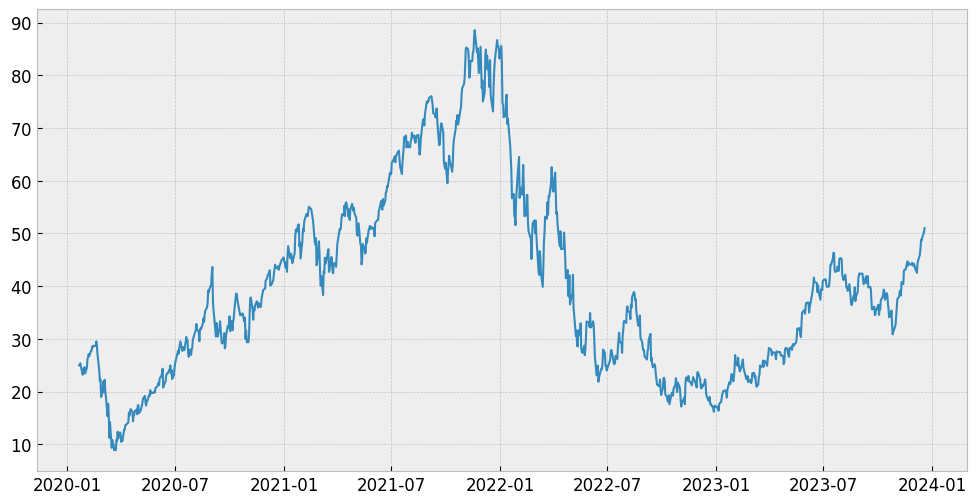

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(df['Close'][:], label='Close Price')

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

# 데이터 가져오기
start = '2018-01-01'
end = '2022-12-31'
stock = 'NAIL'  # NAIL ETF의 심볼

# Yahoo Finance에서 주식 데이터 가져오기
df = web.DataReader(stock, 'yahoo', start, end)

# 간단한 이동 평균 전략 구현
short_window = 40
long_window = 100

df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()

# 매수/매도 신호 생성
df['Signal'] = 0
df['Signal'][short_window:] = np.where(df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1, 0)
df['Position'] = df['Signal'].diff()

# 백테스팅 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Short_MA'], label='40-Day Moving Average')
plt.plot(df['Long_MA'], label='100-Day Moving Average')

plt.plot(df[df['Position'] == 1].index, df['Short_MA'][df['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df[df['Position'] == -1].index, df['Short_MA'][df['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('NAIL ETF Backtest')
plt.legend()
plt.show()

TypeError: ignored

In [ ]:
pip install --upgrade pandas_datareader

[*********************100%%**********************]  1 of 1 completed


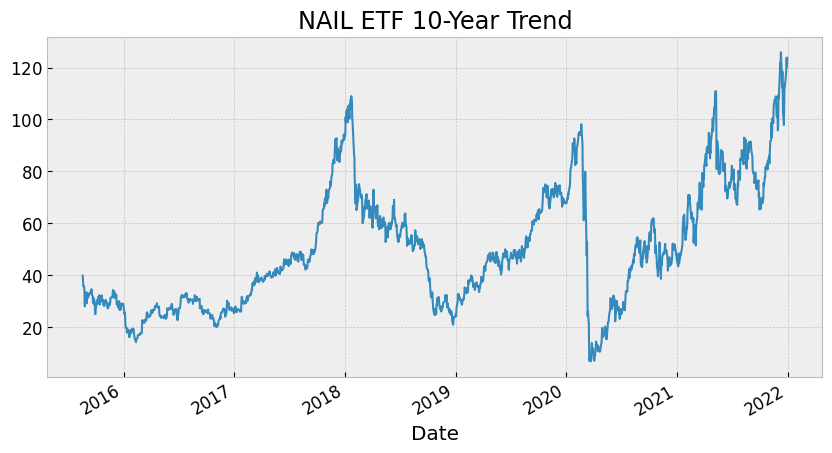

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# 데이터 가져오기
df = yf.download('NAIL', start='2012-01-01', end='2022-01-01')
df['Close'].plot(title='NAIL ETF 10-Year Trend')
plt.show()

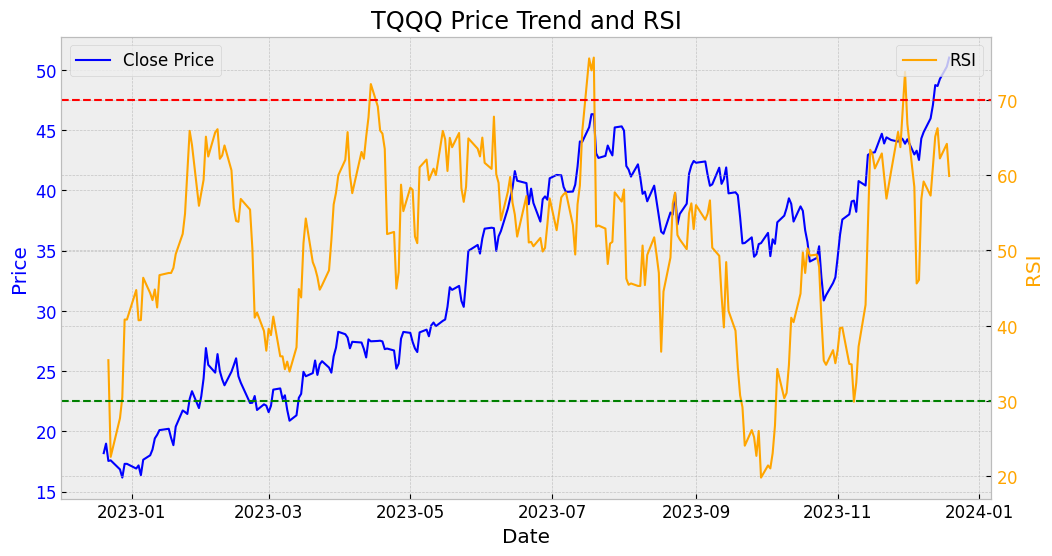

In [ ]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# RSI 계산 함수 정의
def compute_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = 0 + diff.where(diff > 0)
    loss = 0 - diff.where(diff < 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 지난 3개월 데이터 가져오기
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# TQQQ 주식 데이터 가져오기
# df = pdr.DataReader('TQQQ', 'yahoo', start_date, end_date)
df = fs.get_ohlc('TQQQ', start_date, end_date)

# RSI 계산
df['RSI'] = compute_rsi(df['Close'])

# 가격 추세와 RSI 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 주가 데이터 (왼쪽 y축)
ax1.plot(df.index, df['Close'], color='blue', label='Close Price')
ax1.set_title('TQQQ Price Trend and RSI')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# RSI 데이터 (오른쪽 y축)
ax2 = ax1.twinx()  # 같은 x축을 공유하는 새로운 y축 생성
ax2.plot(df.index, df['RSI'], color='orange', label='RSI')
ax2.set_ylabel('RSI', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='green', linestyle='--')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
pip install --upgrade pandas_datareader

In [ ]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import yfinance as yf

# RSI 계산 함수
def compute_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# RSI 모멘텀 계산 함수
def calculate_momentum_of_rsi(rsi_series, window=5):
    return rsi_series.diff(periods=window)

# 트렌드 모멘텀 계산 함수
def calculate_trend_momentum(data, short_window=5, long_window=20):
    short_rolling = data.rolling(window=short_window).mean()
    long_rolling = data.rolling(window=long_window).mean()
    return short_rolling - long_rolling

# TQQQ 데이터 가져오기
end_date = datetime.now().strftime('%Y-%m-%d')
# df = web.DataReader('TQQQ', 'yahoo', '2015-01-01', end_date)
df = yf.download('TQQQ', start='2015-01-01', end=end_date)

# RSI 계산
df['RSI'] = compute_rsi(df['Close'])

# RSI 모멘텀 계산
df['RSI_Momentum'] = calculate_momentum_of_rsi(df['RSI'])

# 트렌드 모멘텀 계산
df['Trend_Momentum'] = calculate_trend_momentum(df['Close'])

# 오늘의 RSI, RSI 모멘텀, 트렌드 모멘텀
today_rsi = df['RSI'].iloc[-1]
today_rsi_momentum = df['RSI_Momentum'].iloc[-1]
today_trend_momentum = df['Trend_Momentum'].iloc[-1]

print(f"Today's RSI: {today_rsi}")
print(f"Today's RSI Momentum: {today_rsi_momentum}")
print(f"Today's Trend Momentum: {today_trend_momentum}")

[*********************100%%**********************]  1 of 1 completed
Today's RSI: 81.89532678108418
Today's RSI Momentum: 3.019725414553264
Today's Trend Momentum: 3.2149997711181655


In [ ]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime
import finterstellar as fs

# RSI 계산 함수 정의
def compute_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# TQQQ 데이터 가져오기 (2015년부터 현재까지)
# df = web.DataReader('TQQQ', 'yahoo', '2015-01-01', datetime.now().strftime('%Y-%m-%d'))
df = fs.get_ohlc('TQQQ', '2015-01-01', '2023-12-30')
저건

# RSI 계산
df['RSI'] = compute_rsi(df['Close'])


def calculate_momentum_of_rsi(rsi_series, window=5):
    """
    Calculate the momentum of RSI (Relative Strength Index) over a given window.

    :param rsi_series: Pandas Series, RSI values
    :param window: int, the window size to calculate momentum
    :return: Pandas Series, momentum of RSI
    """
    return rsi_series.diff(periods=window)

# Example usage:
# Assuming `rsi_data` is a Pandas Series of RSI values
# momentum_rsi = calculate_momentum_of_rsi(rsi_data, window=5)

df['RSI_Momentum'] = calculate_momentum_of_rsi(df['RSI'], window=5)


# 연도별 차트 그리기
for year in range(2015, datetime.now().year + 1):
    year_data = df[df.index.year == year]

    if not year_data.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        negative_momentum_data = year_data[(year_data['RSI'] < 30) & (year_data['RSI_Momentum'] < 0)]

        # RSI Momentum (left y-axis)
        # ax1.plot(year_data.index, year_data['RSI_Momentum'], color='blue', label='RSI Momentum')
        # ax1.plot(negative_momentum_data.index, negative_momentum_data['RSI_Momentum'], color='red', label='Negative RSI Momentum')

        # 주가 추세 (왼쪽 y축)
        ax1.plot(year_data.index, year_data['Close'], color='blue', label='Close Price')
        ax1.scatter(negative_momentum_data.index, negative_momentum_data['Close'], color='red', s=50 , label='Negative RSI Momentum')
        ax1.set_title(f'TQQQ Trend and RSI for {year}')
        ax1.set_ylabel('Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # ax1.plot(year_data.index, year_data['RSI_Momentum'], color='blue', label='RSI Momentum')
        # ax1.set_title(f'TQQQ Trend and RSI Momentum for {year}')
        # ax1.set_ylabel('Momentum', color='blue')
        # ax1.tick_params(axis='y', labelcolor='blue')
        # ax1.axhline(0, color='red', linestyle='--')

        # RSI (오른쪽 y축)
        ax2 = ax1.twinx()
        ax2.plot(year_data.index, year_data['RSI'], color='orange', label='RSI')
        ax2.set_ylabel('RSI', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        ax2.axhline(30, color='green', linestyle='--')


        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()

ModuleNotFoundError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Dummy DataFrame creation for demonstration
dates = pd.date_range(start='2015-01-01', end='2023-12-19', freq='B')
df = pd.DataFrame(index=dates)
df['Close'] = (np.random.rand(len(dates)) - 0.5).cumsum() + 100  # Random close prices
df['RSI'] = np.random.rand(len(dates)) * 100  # Random RSI values between 0 and 100

# RSI Momentum Calculation Function
def calculate_momentum_of_rsi(rsi_series, window=5):
    return rsi_series.diff(periods=window)

# Calculate RSI Momentum
df['RSI_Momentum'] = calculate_momentum_of_rsi(df['RSI'], window=5)

# Plotting each year's RSI and RSI Momentum
for year in range(2015, datetime.now().year + 1):
    year_data = df[df.index.year == year]

    if not year_data.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Filtering for RSI < 40 and negative momentum
        negative_momentum_data = year_data[(year_data['RSI'] < 40) & (year_data['RSI_Momentum'] < 0)]

        # RSI Momentum (left y-axis)
        ax1.plot(year_data.index, year_data['RSI_Momentum'], color='blue', label='RSI Momentum')
        ax1.plot(negative_momentum_data.index, negative_momentum_data['RSI_Momentum'], color='red', label='Negative RSI Momentum')
        ax1.set_title(f'TQQQ RSI Momentum for {year}')
        ax1.set_ylabel('Momentum', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.axhline(0, color='red', linestyle='--')

        # RSI (right y-axis)
        ax2 = ax1.twinx()
        ax2.plot(year_data.index, year_data['RSI'], color='orange', label='RSI')
        ax2.set_ylabel('RSI', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        ax2.axhline(40, color='green', linestyle='--')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()

In [ ]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

# RSI 계산 함수
def compute_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 초기 설정
initial_capital = 10000
buy_unit = initial_capital / 40
remaining_capital = initial_capital
stock_holdings = 0
average_buy_price = 0

# TQQQ 데이터 가져오기
# df = web.DataReader('TQQQ', 'yahoo', '2020-01-01', datetime.now().strftime('%Y-%m-%d'))
df = fs.get_ohlc('TQQQ', '2015-01-01', '2023-12-19')
df['RSI'] = compute_rsi(df['Close'])

# 매수 및 매도 로직
for index, row in df.iterrows():
    if remaining_capital > 0:
        # 매수
        if stock_holdings == 0:  # 첫 날 매수
            num_shares_to_buy = buy_unit / row['Close']
        else:
            # 주가가 평균 매입가 이하이면 1/40, 이상이면 1/80 매수
            buy_ratio = 1/40 if row['Close'] <= average_buy_price else 1/80
            num_shares_to_buy = (buy_ratio * remaining_capital) / row['Close']

        # 매수 가능 여부 확인
        cost = num_shares_to_buy * row['Close']
        if cost <= remaining_capital:
            remaining_capital -= cost
            stock_holdings += num_shares_to_buy
            average_buy_price = ((average_buy_price * (stock_holdings - num_shares_to_buy)) + cost) / stock_holdings

    elif stock_holdings > 0 and row['RSI'] >= 70 and ((row['Close'] / average_buy_price) - 1) >= 0.1:
        # 매도
        profit = stock_holdings * row['Close']
        remaining_capital += profit
        stock_holdings = 0
        average_buy_price = 0

# 최종 결과 출력
print(f'Final Capital: ${remaining_capital:.2f}')
print(f'Stock Holdings: {stock_holdings} shares')

Final Capital: $0.00
Stock Holdings: 2373.580550013929 shares


In [ ]:
import pandas as pd
import finterstellar as fs

# RSI 계산 함수 정의
def compute_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 초기 설정
initial_capital = 100000
remaining_capital = initial_capital
stock_holdings = 0
average_buy_price = 0

# TQQQ 주식 데이터 가져오기
df = fs.get_ohlc('TQQQ', '2018-01-01', '2023-12-19')
df['RSI'] = compute_rsi(df['Close'])

# 매수 및 매도 로직
for index, row in df.iterrows():
    if remaining_capital > 0:
        # 매수
        buy_unit = remaining_capital / 40 if stock_holdings == 0 else remaining_capital / 80
        num_shares_to_buy = buy_unit / row['Close']
        cost = num_shares_to_buy * row['Close']

        if cost <= remaining_capital:
            remaining_capital -= cost
            stock_holdings += num_shares_to_buy
            average_buy_price = ((average_buy_price * (stock_holdings - num_shares_to_buy)) + cost) / stock_holdings

    elif stock_holdings > 0 and row['RSI'] >= 70 and ((row['Close'] / average_buy_price) - 1) >= 0.10:
        # 매도
        profit = stock_holdings * row['Close']
        remaining_capital += profit
        stock_holdings = 0
        average_buy_price = 0

# 최종 결과 출력
final_stock_value = stock_holdings * df.iloc[-1]['Close']
total_value = remaining_capital + final_stock_value
print(f'Initial Investment: ${initial_capital:.2f}')
print(f'Current Stock Holdings: {stock_holdings} shares')
print(f'Total Value (Stock + Cash): ${total_value:.2f}')

Initial Investment: $100000.00
Current Stock Holdings: 7384.506946499716 shares
Total Value (Stock + Cash): $376757.55


In [ ]:
import pandas as pd
import finterstellar as fs

# 전역 변수 설정
initial_capital = 100000
capital = initial_capital
stock_holdings = 0
average_buy_price = 0

# RSI 계산 함수
def compute_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 매수 함수
def buy_stock(row, buy_fraction):
    global capital, stock_holdings, average_buy_price
    buy_amount = capital * buy_fraction
    num_shares_to_buy = min(buy_amount / row['Close'], capital / row['Close'])
    cost = num_shares_to_buy * row['Close']

    if cost <= capital:
        capital -= cost
        stock_holdings += num_shares_to_buy
        if stock_holdings > 0:
            average_buy_price = ((average_buy_price * (stock_holdings - num_shares_to_buy)) + cost) / stock_holdings

# 매도 함수
def sell_stock(row):
    global capital, stock_holdings, average_buy_price
    if stock_holdings > 0 and row['RSI'] >= 70 and ((row['Close'] / average_buy_price) - 1) >= 0.05:
        capital += stock_holdings * row['Close']
        stock_holdings = 0
        average_buy_price = 0

# TQQQ 데이터 가져오기
df = fs.get_ohlc('TQQQ', '2018-01-01', '2023-12-19')
df['RSI'] = compute_rsi(df['Close'])

# 백테스팅 로직
for index, row in df.iterrows():
    if capital > 0:
        if stock_holdings == 0:
            buy_stock(row, 1/40)  # 첫 매수
        else:
            buy_stock(row, 1/40 if row['Close'] <= average_buy_price else 1/80)  # 후속 매수
    sell_stock(row)  # 매도

# 최종 결과 출력
final_stock_value = stock_holdings * df.iloc[-1]['Close']
total_value = capital + final_stock_value
print(f'Initial Investment: ${initial_capital:.2f}')
print(f'Current Stock Holdings: {stock_holdings} shares')
print(f'Total Value (Stock + Cash): ${total_value:.2f}')

Initial Investment: $100000.00
Current Stock Holdings: 5874.683021851798 shares
Total Value (Stock + Cash): $299727.11


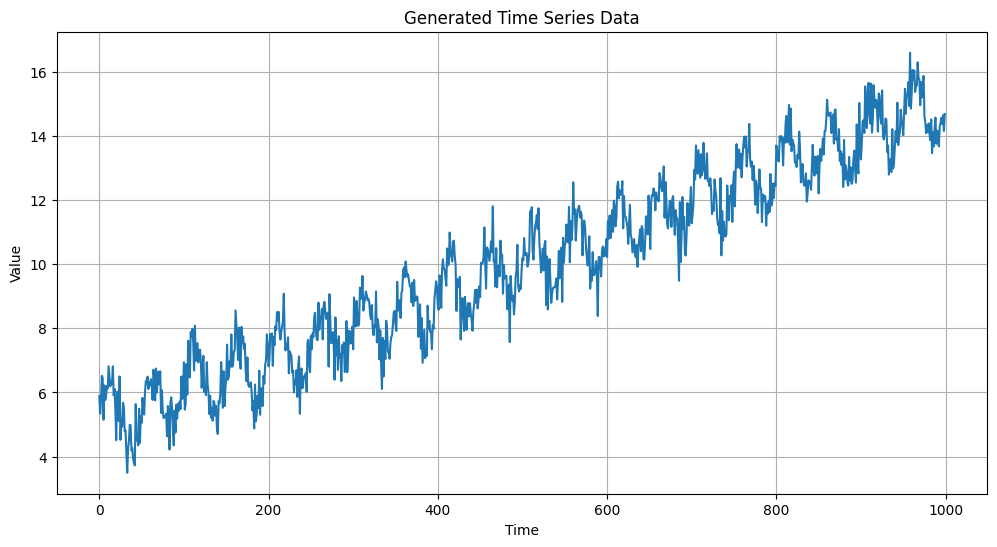

   Time     Value
0     0  5.882026
1     1  5.335412
2     2  5.758059
3     3  6.518571
4     4  6.455533


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 시계열 데이터 생성을 위한 파라미터 설정
np.random.seed(0)
total_steps = 1000
time = np.arange(0, total_steps)
slope = 0.01
intercept = 5
seasonality_period = 50
noise_level = 0.5

# 선형 추세 생성
trend = time * slope + intercept

# 계절성 패턴 생성
seasonality = np.sin(2 * np.pi * time / seasonality_period)

# 노이즈 추가
noise = np.random.normal(0, noise_level, total_steps)

# 최종 시계열 데이터 생성
time_series_data = trend + seasonality + noise

# 데이터를 DataFrame으로 변환
df = pd.DataFrame({'Time': time, 'Value': time_series_data})

# 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Value'])
plt.title('Generated Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# 데이터프레임 반환
print(df.head())


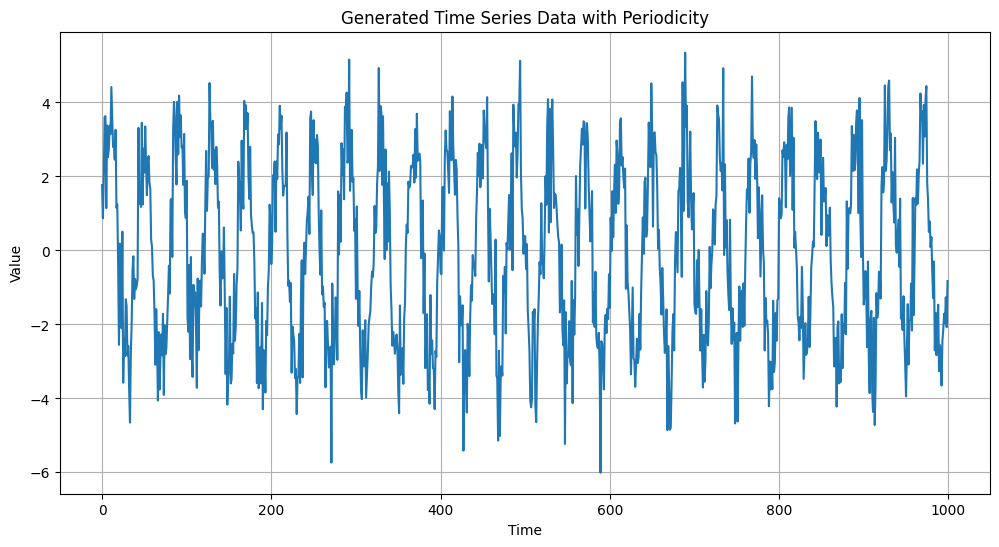

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 시계열 데이터 생성을 위한 파라미터 설정
np.random.seed(0)
total_steps = 1000
time = np.arange(0, total_steps)
amplitude = 3  # 진폭 설정
frequency = 0.025  # 주기 설정
noise_level = 1.0

# 주기적인 패턴 생성
periodic_pattern = amplitude * np.sin(2 * np.pi * frequency * time)

# 노이즈 추가
noise = np.random.normal(0, noise_level, total_steps)

# 최종 시계열 데이터 생성
time_series_data = periodic_pattern + noise

# 데이터를 DataFrame으로 변환
df = pd.DataFrame({'Time': time, 'Value': time_series_data})

# 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Value'])
plt.title('Generated Time Series Data with Periodicity')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
가추가추가